# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [4]:
17

17

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.tsa.filters.filtertools import convolution_filter
from statsmodels.tsa.seasonal import _extrapolate_trend
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from warnings import filterwarnings 
filterwarnings('ignore')
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel, RFE 
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import time


In [7]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [8]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



<Axes: xlabel='y', ylabel='count'>

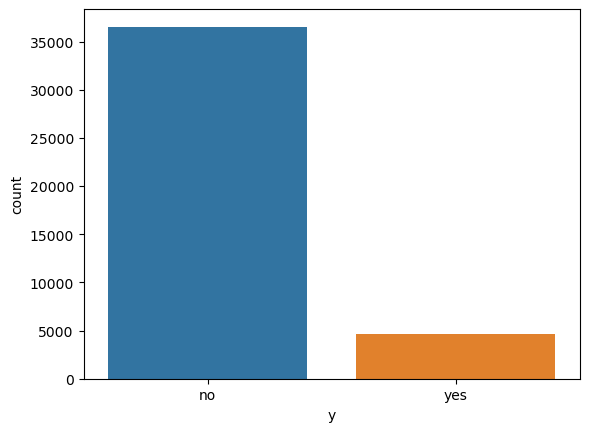

In [10]:
sns.countplot(x='y', data=df)

In [11]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [12]:
num_col = df.select_dtypes(include=np.number)
num_col.corr()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333
emp.var.rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970
cons.price.idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034
cons.conf.idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154
nr.employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [15]:
df = df.drop(['duration'], axis = 1)

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [17]:
# Importing LabelEncoder from Sklearn library from preprocessing Module.
from sklearn.preprocessing import LabelEncoder

# Creating a instance of label Encoder.
le = LabelEncoder()


# Using .fit_transform function to fit label encoder and return encoded label
job_label = le.fit_transform(df['job'])
marital_label = le.fit_transform(df['marital'])
education_label = le.fit_transform(df['education'])
default_label = le.fit_transform(df['default'])
housing_label = le.fit_transform(df['housing'])
loan_label = le.fit_transform(df['loan'])
contact_label = le.fit_transform(df['contact'])
month_label = le.fit_transform(df['month'])
day_of_week_label = le.fit_transform(df['day_of_week'])
poutcome_label = le.fit_transform(df['poutcome'])
y_label = le.fit_transform(df['y'])


# removing each column from df as it is of no use now.
df.drop("job", axis=1, inplace=True)
df.drop("marital", axis=1, inplace=True)
df.drop("education", axis=1, inplace=True)
df.drop("default", axis=1, inplace=True)
df.drop("housing", axis=1, inplace=True)
df.drop("loan", axis=1, inplace=True)
df.drop("contact", axis=1, inplace=True)
df.drop("month", axis=1, inplace=True)
df.drop("day_of_week", axis=1, inplace=True)
df.drop("poutcome", axis=1, inplace=True)
df.drop("y", axis=1, inplace=True)


# Appending the array to our dataFrame with each column name 
df["job"] = job_label
df["marital"] = marital_label
df["education"] = education_label
df["default"] = default_label
df["housing"] = housing_label
df["loan"] = loan_label
df["contact"] = contact_label
df["month"] = month_label
df["day_of_week"] = day_of_week_label
df["poutcome"] = poutcome_label
df["y"] = y_label


# printing Dataframe
df.sample(10)

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
15264,23,3,999,0,1.4,93.918,-42.7,4.958,5228.1,9,1,5,0,0,0,0,3,2,1,0
24029,37,1,999,0,-0.1,93.798,-40.4,4.936,5195.8,0,2,3,0,2,0,1,8,4,1,1
530,36,2,999,0,1.1,93.994,-36.4,4.857,5191.0,0,1,3,0,0,0,1,6,3,1,0
2463,58,3,999,0,1.1,93.994,-36.4,4.856,5191.0,11,1,0,0,0,2,1,6,3,1,0
34255,38,3,999,0,-1.8,92.893,-46.2,1.266,5099.1,1,1,0,0,0,0,0,6,2,1,0
13707,48,1,999,0,1.4,93.918,-42.7,4.963,5228.1,9,0,5,0,2,0,1,3,2,1,0
33640,38,5,999,0,-1.8,92.893,-46.2,1.281,5099.1,1,2,2,0,2,0,1,6,4,1,0
30714,30,1,999,0,-1.8,92.893,-46.2,1.344,5099.1,0,2,3,0,0,0,0,6,3,1,0
18044,34,2,999,0,1.4,93.918,-42.7,4.963,5228.1,9,2,5,1,2,0,0,3,4,1,0
17713,36,1,999,0,1.4,93.918,-42.7,4.961,5228.1,0,1,6,0,2,0,0,3,3,1,0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   campaign        41188 non-null  int64  
 2   pdays           41188 non-null  int64  
 3   previous        41188 non-null  int64  
 4   emp.var.rate    41188 non-null  float64
 5   cons.price.idx  41188 non-null  float64
 6   cons.conf.idx   41188 non-null  float64
 7   euribor3m       41188 non-null  float64
 8   nr.employed     41188 non-null  float64
 9   job             41188 non-null  int64  
 10  marital         41188 non-null  int64  
 11  education       41188 non-null  int64  
 12  default         41188 non-null  int64  
 13  housing         41188 non-null  int64  
 14  loan            41188 non-null  int64  
 15  contact         41188 non-null  int64  
 16  month           41188 non-null  int64  
 17  day_of_week     41188 non-null 

In [19]:
#sns.pairplot(df, hue="y")

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [21]:
X = df.drop('y', axis = 1)
y = df['y']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = .25, random_state=42, stratify = y)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [23]:
linear_pipe = Pipeline([ ('scaler', StandardScaler()),
                          ('model', LinearRegression())])

linear_start_time = time.time()
linear_model = linear_pipe.fit(X_train, y_train)
linear_train_preds = linear_model.predict(X_train)
linear_test_preds = linear_model.predict(X_test)
linear_train_mse = mean_squared_error(y_train, linear_train_preds)
linear_test_mse = mean_squared_error(y_test, linear_test_preds)
linear_train_score = linear_model.score(X_train, y_train)
linear_test_score = linear_model.score(X_test, y_test)
linear_time = time.time() - linear_start_time



# ANSWER CHECK
print(f'Linear Regression Fitting Time: {linear_time}')
print(f'Linear Regression Train MSE: {linear_train_mse}')
print(f'Linear Regression Test MSE: {linear_test_mse}')
print(f'Linear RegressionTrain Score: {linear_train_score}')
print(f'Linear Regression Test Score: {linear_test_score}')

Linear Regression Fitting Time: 0.07053422927856445
Linear Regression Train MSE: 0.08029758511867915
Linear Regression Test MSE: 0.07853281229925871
Linear RegressionTrain Score: 0.19672861601383884
Linear Regression Test Score: 0.21438283940028113


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [25]:
lgr_pipe = Pipeline([ ('scaler', StandardScaler()),
                          ('lgr', LogisticRegression())])

lgr_start_time = time.time()
lgr_model = lgr_pipe.fit(X_train, y_train)
lgr_time = time.time() - lgr_start_time



# ANSWER CHECK
print(f'Logistic Regression Fitting Time: {lgr_time}')


Logistic Regression Fitting Time: 0.10578012466430664


### Problem 9: Score the Model

What is the accuracy of your model?

In [27]:
lgr_train_score = lgr_model.score(X_train, y_train)
lgr_test_score = lgr_model.score(X_test, y_test)

print(f'Logistic Regression Train Score: {lgr_train_score}')
print(f'Logistic Regression Test Score: {lgr_test_score}')

Logistic Regression Train Score: 0.9002622122948432
Logistic Regression Test Score: 0.9006506749538701


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [29]:
knn_start_time = time.time()
knn_model =  KNeighborsClassifier().fit(X_train, y_train)
knn_train_score = knn_model.score(X_train, y_train)
knn_test_score = knn_model.score(X_test, y_test)
knn_time = time.time() - knn_start_time


print(f'K-N Neighbors Fitting Time: {knn_time}')
print(f'K-N Neighbors Train Score: {knn_train_score}')
print(f'K-N Neighbors Test Score: {knn_test_score}')

K-N Neighbors Fitting Time: 5.596900224685669
K-N Neighbors Train Score: 0.9111391667475964
K-N Neighbors Test Score: 0.8942410410799262


In [30]:
dt_start_time = time.time()
dt_model = DecisionTreeClassifier(random_state = 42).fit(X_train, y_train)
dt_train_score = dt_model.score(X_train, y_train)
dt_test_score = dt_model.score(X_test, y_test)
dt_time = time.time() - dt_start_time

print(f'Decision Tree Fitting Time: {dt_time}')
print(f'Decision Tree Train Score: {dt_train_score}')
print(f'Decision Tree Test Score: {dt_test_score}')

Decision Tree Fitting Time: 0.24100399017333984
Decision Tree Train Score: 0.9958563983037131
Decision Tree Test Score: 0.8455860930368069


In [31]:
svc_start_time = time.time()
svc_model = SVC().fit(X_train, y_train)
svc_train_score = svc_model .score(X_train, y_train)
svc_test_score = svc_model .score(X_test, y_test)
svc_time = time.time() - svc_start_time


print(f'SVM Fitting Time: {svc_time}')
print(f'SVM Train Score: {svc_train_score}')
print(f'SVM Test Score: {svc_test_score}')

SVM Fitting Time: 68.54318881034851
SVM Train Score: 0.8974458580168981
SVM Test Score: 0.8977372050111683


In [32]:
res_dict = {'Model': ['KNN', 'Logistic Regression', 'SVC', 'Decision Tree'],
           'Train score': [knn_train_score, lgr_train_score, svc_train_score, dt_train_score],
           'Test score': [knn_test_score, lgr_test_score, svc_test_score, dt_test_score],
           'Average fit time': [knn_time, lgr_time, svc_time, dt_time]}
results_df = pd.DataFrame(res_dict).set_index('Model')
print(results_df)

                     Train score  Test score  Average fit time
Model                                                         
KNN                     0.911139    0.894241          5.596900
Logistic Regression     0.900262    0.900651          0.105780
SVC                     0.897446    0.897737         68.543189
Decision Tree           0.995856    0.845586          0.241004


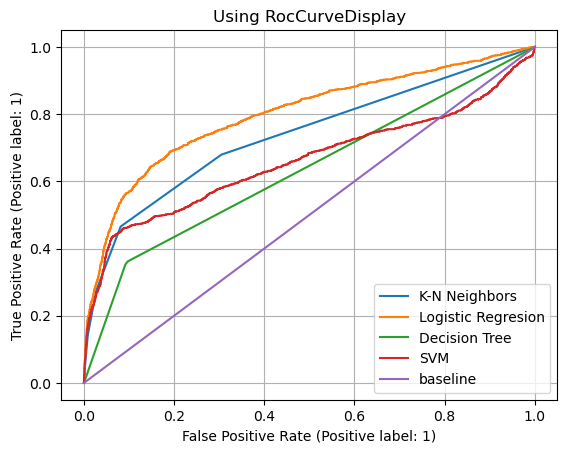

In [43]:
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(knn_model, X_test, y_test,  ax = ax, label = 'K-N Neighbors')
RocCurveDisplay.from_estimator(lgr_model, X_test, y_test,  ax = ax, label = 'Logistic Regresion')
RocCurveDisplay.from_estimator(dt_model, X_test, y_test,  ax = ax, label = 'Decision Tree')
RocCurveDisplay.from_estimator(svc_model, X_test, y_test, ax = ax, label = 'SVM')
plt.grid()
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline');
plt.title('Using RocCurveDisplay')
plt.legend();

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [45]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')
# 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
age,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
campaign,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
pdays,-0.03,0.05,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
previous,0.02,-0.08,-0.59,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
emp.var.rate,-0.00,0.15,0.27,-0.42,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
cons.price.idx,0.00,0.13,0.08,-0.20,0.78,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
cons.conf.idx,0.13,-0.01,-0.09,-0.05,0.20,0.06,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
euribor3m,0.01,0.14,0.30,-0.45,0.97,0.69,0.28,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
nr.employed,-0.02,0.14,0.37,-0.50,0.91,0.52,0.10,0.95,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
job,0.00,-0.01,-0.03,0.02,-0.01,-0.02,0.05,-0.01,-0.02,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [47]:
# Building a Ridge Model

ridge_param_dict = {'ridge__alpha': np.logspace(0, 10, 50)}
ridge_pipe = Pipeline([('scaler', StandardScaler()), 
                      ('ridge', Ridge())])
ridge_start_time = time.time()
ridge_grid = GridSearchCV(ridge_pipe, param_grid=ridge_param_dict)
ridge_grid.fit(X_train, y_train)
ridge_train_score = ridge_grid.score(X_train, y_train)
ridge_test_score = ridge_grid.score(X_test, y_test)
ridge_time = time.time() - ridge_start_time

print(f'Ridge Fitting Time: {ridge_time}')
print(f'Ridge Train Score: {ridge_train_score}')
print(f'Ridge Test Score: {ridge_test_score}')

Ridge Fitting Time: 9.410423994064331
Ridge Train Score: 0.19672852987392297
Ridge Test Score: 0.21438228807181914


In [48]:
best_ridge_model = ridge_grid.best_estimator_.named_steps['ridge']
ridge_coefs = best_ridge_model.coef_

ridge_df = pd.DataFrame({'feature': X_train.columns, 'coef': ridge_coefs})
ridge_df = ridge_df.loc[ridge_df['coef'] != 0]
ridge_sorted = ridge_df.reindex(ridge_df['coef'].abs().sort_values(ascending=False).index)
ridge_sorted 

,feature,coef
4,emp.var.rate,-0.190642
7,euribor3m,0.154268
8,nr.employed,-0.105342
5,cons.price.idx,0.080235
2,pdays,-0.051252
15,contact,-0.042479
16,month,-0.030056
6,cons.conf.idx,0.018913
18,poutcome,0.018598
12,default,-0.007027


In [53]:
X = df[['emp.var.rate','euribor3m','nr.employed','cons.price.idx','pdays', 'contact', 'month']]

In [55]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = .33, random_state=42, stratify = y)

In [57]:
X_train

,emp.var.rate,euribor3m,nr.employed,cons.price.idx,pdays,contact,month
7517,1.1,4.864,5191.0,93.994,999,1,6
21591,1.4,4.963,5228.1,93.444,999,0,1
13925,1.4,4.963,5228.1,93.918,999,0,3
33434,-1.8,1.291,5099.1,92.893,999,0,6
6299,1.1,4.857,5191.0,93.994,999,1,6
...,...,...,...,...,...,...,...
28337,-1.8,1.445,5099.1,93.075,999,0,0
7494,1.1,4.864,5191.0,93.994,999,1,6
10747,1.4,4.961,5228.1,94.465,999,1,4
34138,-1.8,1.281,5099.1,92.893,999,0,6


In [61]:
C = np.logspace(-1.2,-0.5)

coef = np.empty((len(C),7))
for i, c in enumerate(C):
    lr = LogisticRegression(penalty='l1', C=c, solver='liblinear').fit(X_train, y_train)
    coef[i] = lr.coef_

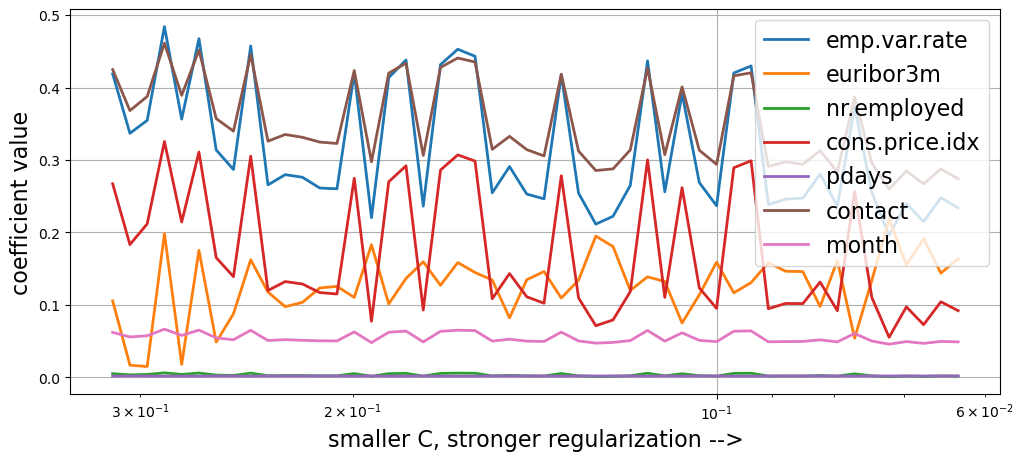

In [62]:
plt.figure(figsize=(12,5))
plt.semilogx(C,abs(coef),linewidth=2)
plt.gca().invert_xaxis()
plt.grid()
plt.legend(X.columns,fontsize=16)
plt.xlabel('smaller C, stronger regularization -->' , fontsize=16)
plt.ylabel('coefficient value', fontsize=16)
plt.show()

In [63]:
X = df[['previous','emp.var.rate', 'contact', 'poutcome', 'default' ]]

In [64]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = .33, random_state=52, stratify = y)
X_train

,previous,emp.var.rate,contact,poutcome,default
13382,0,1.4,1,1,0
17390,0,1.4,0,1,0
28268,1,-1.8,0,0,0
18001,0,1.4,0,1,0
20818,0,1.4,0,1,0
...,...,...,...,...,...
26153,0,-0.1,0,1,1
28352,0,-1.8,0,1,0
37031,1,-2.9,0,0,0
40473,2,-1.7,0,2,0


In [65]:
C = np.logspace(-1.2,-0.5)

coef = np.empty((len(C),5))
for i, c in enumerate(C):
    lr = LogisticRegression(penalty='l1', C=c, solver='liblinear').fit(X_train, y_train)
    coef[i] = lr.coef_

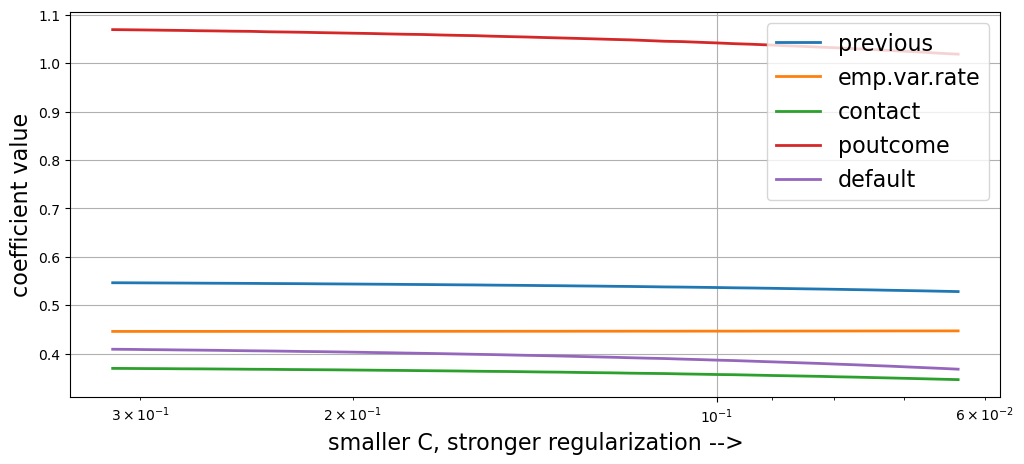

In [66]:
plt.figure(figsize=(12,5))
plt.semilogx(C,abs(coef),linewidth=2)
plt.gca().invert_xaxis()
plt.grid()
plt.legend(X.columns,fontsize=16)
plt.xlabel('smaller C, stronger regularization -->' , fontsize=16)
plt.ylabel('coefficient value', fontsize=16)
plt.show()

In [73]:
params1= {'poly__degree': list(range(1, 6, 1))}
lgr_pipe = Pipeline([('scale', StandardScaler()),
                     ('poly', PolynomialFeatures()),
                 ('lgr', LogisticRegression(multi_class='multinomial'))
                  ])

lgr_start_time = time.time()
lgr_grid = GridSearchCV(lgr_pipe, param_grid=params1)
lgr_grid.fit(X_train, y_train)
lgr_train_preds = lgr_grid.predict(X_train)
lgr_test_preds = lgr_grid.predict(X_test)
lgr_time = time.time() - lgr_start_time
lgr_best_params = lgr_grid.best_params_


# ANSWER CHECK
print(f'Logistic Regression Fitting Time: {lgr_time}')
print(f'Logistic Regression Best Model: {lgr_best_params}')
print(f'Logistic Regression Train Score: {lgr_train_score}')
print(f'Logistic Regression Test Score: {lgr_test_score}')

Logistic Regression Fitting Time: 37.49020576477051
Logistic Regression Best Model: {'poly__degree': 3}
Logistic Regression Train Score: 0.9002622122948432
Logistic Regression Test Score: 0.9006506749538701


In [74]:
params2= {'knn__n_neighbors': list(range(1, 22, 2)),
          'knn__weights': ['uniform', 'distance'],
          'knn__p': [1, 2]}

knn_start_time = time.time()
knn_pipe = Pipeline([('scale', StandardScaler()), ('knn', KNeighborsClassifier())])
knn_grid = GridSearchCV(knn_pipe, param_grid=params2)
knn_grid.fit(X_train, y_train)
knn_train_score = knn_grid.score(X_train, y_train)
knn_test_score = knn_grid.score(X_test, y_test)
knn_time = time.time() - knn_start_time
knn_best_params = knn_grid.best_params_


print(f'K-N Neighbors Fitting Time: {knn_time}')
print(f'K-N Neighbors Best Model: {knn_best_params}')
print(f'K-N Neighbors Train Score: {knn_train_score}')
print(f'K-N Neighbors Test Score: {knn_test_score}')

K-N Neighbors Fitting Time: 117.01214098930359
K-N Neighbors Best Model: {'knn__n_neighbors': 19, 'knn__p': 1, 'knn__weights': 'uniform'}
K-N Neighbors Train Score: 0.8971190433049465
K-N Neighbors Test Score: 0.8978886191422055


In [75]:
dt_start_time = time.time()
params3 = {'dtree__min_impurity_decrease': [0.01, 0.02, 0.03, 0.05],
         'dtree__max_depth': [2, 5, 10],
         'dtree__min_samples_split': [0.1, 0.2, 0.05]}
dt_pipe = Pipeline([('scale', StandardScaler()), ('dtree', DecisionTreeClassifier(random_state = 22))])
dt_grid = GridSearchCV(dt_pipe, param_grid=params3).fit(X_train, y_train)
dt_train_score = dt_grid.score(X_train, y_train)
dt_test_score = dt_grid.score(X_test, y_test)
dt_time = time.time() - dt_start_time
dt_best_params = dt_grid.best_params_

print(f'Decision Tree Fitting Time: {dt_time}')
print(f'Decision Tree Best Model: {dt_best_params}')
print(f'Decision Tree Train Score: {dt_train_score}')
print(f'Decision Tree Test Score: {dt_test_score}')

Decision Tree Fitting Time: 4.609488010406494
Decision Tree Best Model: {'dtree__max_depth': 2, 'dtree__min_impurity_decrease': 0.01, 'dtree__min_samples_split': 0.1}
Decision Tree Train Score: 0.8973727124479073
Decision Tree Test Score: 0.8975207827558302


In [80]:
svc_start_time = time.time()
params4= {'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
svc_pipe = Pipeline([('scale', StandardScaler()), ('svc', SVC())])
svc_grid = GridSearchCV(svc_pipe, param_grid=params4)
svc_grid.fit(X_train, y_train)
svc_train_score = svc_grid.score(X_train, y_train)
svc_test_score = svc_grid.score(X_test, y_test)
svc_time = time.time() - svc_start_time
svc_best_params = svc_grid.best_params_


print(f'SVM Fitting Time: {svc_time}')
print(f'SVM Best Model: {svc_best_params}')
print(f'SVM Train Score: {svc_train_score}')
print(f'SVM Test Score: {svc_test_score}')

SVM Fitting Time: 3149.510994911194
SVM Best Model: {'svc__kernel': 'rbf'}
SVM Train Score: 0.897735096937851
SVM Test Score: 0.8978886191422055


In [84]:
res_dict2 = {'Model': ['KNN', 'Logistic Regression', 'SVC', 'Decision Tree'],
            'Average fit time': [knn_time, lgr_time, svc_time, dt_time],
           'Train score': [knn_train_score, lgr_train_score, svc_train_score, dt_train_score],
           'Test score': [knn_test_score, lgr_test_score, svc_test_score, dt_test_score],
           'Best Model Parameters': [knn_best_params, lgr_best_params, svc_best_params, dt_best_params]}
results_df2 = pd.DataFrame(res_dict2).set_index('Model')
print(results_df2)

                     Average fit time  Train score  Test score  \
Model                                                            
KNN                        117.012141     0.897119    0.897889   
Logistic Regression         37.490206     0.900262    0.900651   
SVC                       3149.510995     0.897735    0.897889   
Decision Tree                4.609488     0.897373    0.897521   

                                                 Best Model Parameters  
Model                                                                   
KNN                  {'knn__n_neighbors': 19, 'knn__p': 1, 'knn__we...  
Logistic Regression                                {'poly__degree': 3}  
SVC                                             {'svc__kernel': 'rbf'}  
Decision Tree        {'dtree__max_depth': 2, 'dtree__min_impurity_d...  


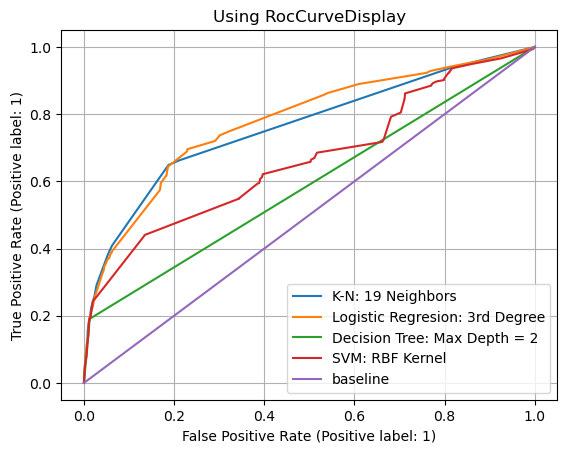

In [86]:
fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(knn_grid, X_test, y_test,  ax = ax, label = 'K-N: 19 Neighbors')
RocCurveDisplay.from_estimator(lgr_grid, X_test, y_test,  ax = ax, label = 'Logistic Regresion: 3rd Degree')
RocCurveDisplay.from_estimator(dt_grid, X_test, y_test,  ax = ax, label = 'Decision Tree: Max Depth = 2')
RocCurveDisplay.from_estimator(svc_grid, X_test, y_test, ax = ax, label = 'SVM: RBF')
plt.grid()
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline');
plt.title('Using RocCurveDisplay')
plt.legend();

## Testing the model designed by Moro & Laureano (without Duration)

In [110]:
X = df[['month','previous','pdays',  'poutcome', 'contact']]

In [112]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = .33, random_state=52, stratify = y)
X_train

,month,previous,pdays,poutcome,contact
13382,3,0,999,1,1
17390,3,0,999,1,0
28268,0,1,999,0,0
18001,3,0,999,1,0
20818,1,0,999,1,0
...,...,...,...,...,...
26153,7,0,999,1,0
28352,0,0,999,1,0
37031,3,1,999,0,0
40473,1,2,6,2,0


In [114]:
params1= {'poly__degree': list(range(1, 6, 1))}
lgr_pipe = Pipeline([('scale', StandardScaler()),
                     ('poly', PolynomialFeatures()),
                 ('lgr', LogisticRegression(multi_class='multinomial'))
                  ])

lgr_start_time = time.time()
lgr_grid = GridSearchCV(lgr_pipe, param_grid=params1)
lgr_grid.fit(X_train, y_train)
lgr_train_preds = lgr_grid.predict(X_train)
lgr_test_preds = lgr_grid.predict(X_test)
lgr_time = time.time() - lgr_start_time
lgr_best_params = lgr_grid.best_params_


# ANSWER CHECK
print(f'Logistic Regression Fitting Time: {lgr_time}')
print(f'Logistic Regression Best Model: {lgr_best_params}')
print(f'Logistic Regression Train Score: {lgr_train_score}')
print(f'Logistic Regression Test Score: {lgr_test_score}')

Logistic Regression Fitting Time: 20.26620602607727
Logistic Regression Best Model: {'poly__degree': 2}
Logistic Regression Train Score: 0.9002622122948432
Logistic Regression Test Score: 0.9006506749538701


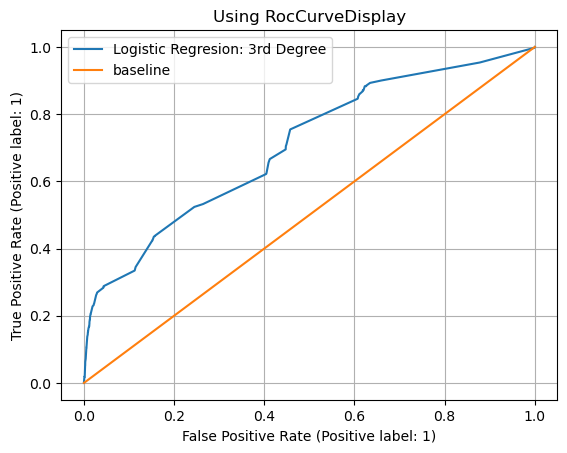

In [116]:
fig, ax = plt.subplots()
#RocCurveDisplay.from_estimator(knn_grid, X_test, y_test,  ax = ax, label = 'K-N: 19 Neighbors')
RocCurveDisplay.from_estimator(lgr_grid, X_test, y_test,  ax = ax, label = 'Logistic Regresion: 3rd Degree')
#RocCurveDisplay.from_estimator(dt_grid, X_test, y_test,  ax = ax, label = 'Decision Tree: Max Depth = 2')
#RocCurveDisplay.from_estimator(svc_grid, X_test, y_test, ax = ax, label = 'SVM: RBF Kernel')
plt.grid()
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline');
plt.title('Using RocCurveDisplay')
plt.legend();

##### Questions